In [5]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import datasets, layers, models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

2.18.0


In [66]:
test_images_dir = "fire-smoke-detection.v2-v2.yolov8/test/images/"
test_labels_dir = "fire-smoke-detection.v2-v2.yolov8/test/labels/"
train_images_dir = "fire-smoke-detection.v2-v2.yolov8/train/images/"
train_labels_dir = "fire-smoke-detection.v2-v2.yolov8/train/labels/"
valid_images_dir = "fire-smoke-detection.v2-v2.yolov8/valid/images/"
valid_labels_dir = "fire-smoke-detection.v2-v2.yolov8/valid/labels/"


In [47]:
def load_sample_label(txt_path):
    """Txt dosyasından etiket bilgilerini yükler"""
    labels = []
    if os.path.exists(txt_path):
        with open(txt_path, 'r') as file:
            for line in file.readlines():
                parts = line.strip().split()
                if len(parts) == 5:
                    fire_id, x_center, y_center, width, height = map(float, parts)
                    labels.append((int(fire_id), x_center, y_center, width, height))
    return labels

In [62]:
def load_all_labels(label_dir):
    """
    Tüm .txt dosyalarını okuyarak etiketleri NumPy dizisine ekler.
    Dönüş formatı: [filename, fire_id, x_center, y_center, width, height]
    """
    all_labels = []
    txt_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.txt')])

    for txt_file in txt_files:
        txt_path = os.path.join(label_dir, txt_file)
        
        if os.path.exists(txt_path):
            with open(txt_path, 'r') as file:
                for line in file.readlines():
                    parts = line.strip().split()
                    if len(parts) == 5:
                        fire_id, x_center, y_center, width, height = map(float, parts)
                        # Her satır için dosya adı ve etiket bilgilerini ekle
                        all_labels.append([txt_file.replace('.txt', ''), int(fire_id), x_center, y_center, width, height])
    
    # NumPy dizisine çevir
    return np.array(all_labels, dtype=object)

In [72]:
def plot_sample(img, labels):
    """Görüntüyü ve etiketlere göre kare çizerek görselleştir"""

    # Görüntü boyutları
    img_height, img_width, _ = img.shape

    # Her bir etiket için bir dikdörtgen çizelim
    for label in labels:
        fire_id, x_center, y_center, width, height = label
        
        # Orijinal boyutlara göre koordinatları hesapla
        x1 = int((x_center - width / 2) * img_width)
        y1 = int((y_center - height / 2) * img_height)
        x2 = int((x_center + width / 2) * img_width)
        y2 = int((y_center + height / 2) * img_height)
        
        # fire_id'ye göre etiket belirle
        if fire_id == 0:
            label_text = "Fire"
            color = (255, 0, 0)  # Kırmızı
        elif fire_id == 1:
            label_text = "Smoke"
            color = (0, 255, 0)  # Yeşil
        else:
            label_text = "Unknown"
            color = (0, 0, 255)  # Mavi (beklenmeyen fire_id için)

        # Kare çiz ve etiket yazısı ekle
        img = cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        img = cv2.putText(img, label_text, (x1, y1 - 10), 
                          cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Görüntüyü göster
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [63]:
def load_images(image_dir):
    """
    Tüm .jpg dosyalarını okuyarak NumPy dizisine ekler.
    Dönüş formatı: [filename, image_array]
    """
    all_images = []
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        # Görüntüyü yükle ve RGB formatına çevir
        img = cv2.imread(image_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Görüntü verisini dosya adı ile birlikte sakla
            all_images.append([image_file.replace('.jpg', ''), img])
    
    # NumPy dizisine çevir
    return np.array(all_images, dtype=object)


In [65]:
def match_images_and_labels(images_array, labels_array):
    """
    Görüntü ve etiketleri dosya adlarına göre eşleştirir.
    Eşleşen görüntü ve etiketleri içeren bir liste döndürür.
    """
    matched_data = []

    for image_name, image_data in images_array:
        # Aynı isimde bir label var mı kontrol et
        label_data = labels_array[labels_array[:, 0] == image_name]
        
        if len(label_data) > 0:
            matched_data.append([image_name, image_data, label_data[:, 1:]])
    
    return matched_data

In [67]:
all_images = load_images(test_images_dir)
all_labels = load_all_labels(test_labels_dir)

In [68]:
matched_data = match_images_and_labels(all_images, all_labels)

In [70]:
for i in range(min(3, len(matched_data))):
    image_name, image_data, labels = matched_data[i]
    print(f"Image Name: {image_name}")
    print(f"Labels:\n{labels}")
    print(f"Image Shape: {image_data.shape}")
    print("-" * 60)

Image Name: image_108_jpg.rf.d51fd6d7c5e64fdc2464412c20657227
Labels:
[[0 0.38203125 0.46484375 0.16640625 0.2421875]
 [0 0.7765625 0.41953125 0.08515625 0.171875]]
Image Shape: (640, 640, 3)
------------------------------------------------------------
Image Name: image_10_jpg.rf.dc07fca974f159f1a846f5a8b012bd1c
Labels:
[[0 0.86953125 0.43671875 0.14375 0.29453125]]
Image Shape: (640, 640, 3)
------------------------------------------------------------
Image Name: image_128_jpg.rf.876276213683135a0ebacee3150f132d
Labels:
[[0 0.384375 0.34453125 0.2359375 0.52890625]
 [0 0.6203125 0.5625 0.2 0.2265625]]
Image Shape: (640, 640, 3)
------------------------------------------------------------


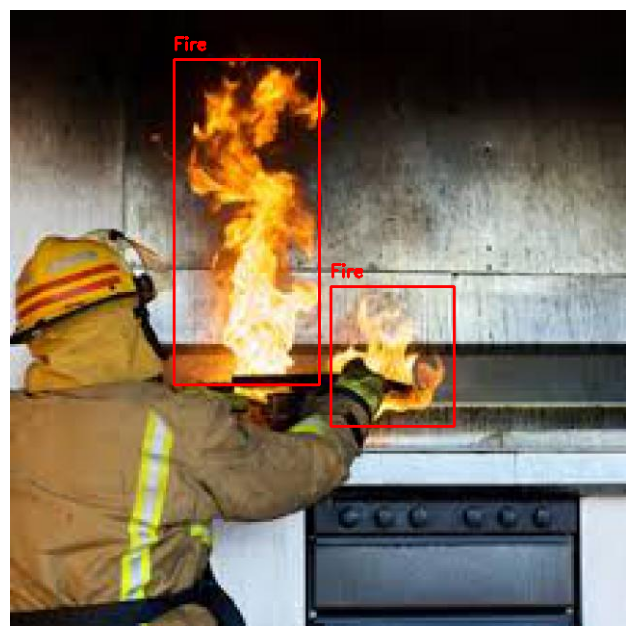

In [76]:
for i in range(min(1, len(matched_data))):
    plot_sample(image_data, labels)

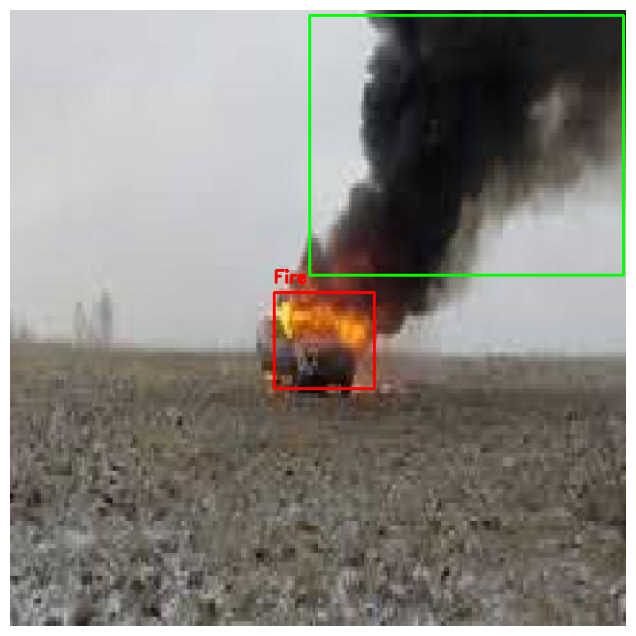

In [86]:
plot_sample(matched_data[15][1], matched_data[15][2])